In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from torch.utils.data import Dataset


In [ ]:
df = pd.read_csv('age_gender.csv')

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

Using cpu


In [ ]:
df['pixel_count'] = df['pixels'].apply(lambda x: len(x.split()))
print(df['pixel_count'].value_counts())
df = df[df['pixel_count'] == 2304].copy()
df.drop(columns=['pixel_count'], inplace=True)

pixel_count
2304    23705
Name: count, dtype: int64


# **AgeCNN**

In [ ]:
def discretize_age(age):
    if age <= 1:
        return 0 # baby
    elif age <= 10:
        return 1 # child
    elif age <= 19:
        return 2 # teenager
    elif age <= 25:
        return 3 # young adult
    elif age <= 40:
        return 4 # adult
    elif age <= 50:
        return 5 # middle-aged
    else:
        return 6 # senior

df['discretized_age'] = df['age'].apply(discretize_age)

In [ ]:
class AgeCNN(nn.Module):
    def __init__(self):
        super(AgeCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 6 * 6, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 7)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc(x)
        return x

model = AgeCNN().to(device)

In [ ]:
pixels = np.stack(df['pixels'].apply(lambda x: np.array(x.split(), dtype=np.uint8).reshape(48, 48))) / 255.0
ages = df['discretized_age'].values

pixels = np.expand_dims(pixels, axis=1)

X = torch.tensor(pixels, dtype=torch.float32)
y_age = torch.tensor(ages, dtype=torch.long)

X_train, X_val, y_age_train, y_age_val = train_test_split(
    X, y_age, test_size=0.2, random_state=42
)

batch_size = 32

train_data = TensorDataset(X_train, y_age_train)
val_data = TensorDataset(X_val, y_age_val)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

print(f"Training samples: {len(train_loader.dataset)}, Validation samples: {len(val_loader.dataset)}")

Training samples: 18964, Validation samples: 4741


In [ ]:
criterion_age = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001) # Use Adam optimizer

def train(model, train_loader, optimizer, criterion_age, device):
    model.train()
    total_loss = 0

    for images, ages in train_loader:
        images, ages = images.to(device), ages.to(device)

        optimizer.zero_grad()
        age_preds = model(images)
        loss_age = criterion_age(age_preds, ages)
        loss_age.backward()
        optimizer.step()

        total_loss += loss_age.item()

    return total_loss / len(train_loader)


In [ ]:
def evaluate(model, val_loader, criterion_age, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, ages in val_loader:
            images, ages = images.to(device), ages.to(device)

            outputs = model(images)
            loss = criterion_age(outputs, ages)

            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == ages).sum().item()
            total += ages.size(0)

    avg_loss = total_loss / len(val_loader)
    accuracy = correct / total * 100

    return avg_loss, accuracy

In [ ]:
num_epochs = 5
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, criterion_age, device)  # Use criterion_age
    train_losses.append(train_loss)

    val_loss, val_accuracy = evaluate(model, val_loader, criterion_age, device)  # Use criterion_age
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

Epoch 1/5, Train Loss: 1.4117, Val Loss: 1.2863, Val Accuracy: 52.75%
Epoch 2/5, Train Loss: 1.1699, Val Loss: 1.0074, Val Accuracy: 60.30%
Epoch 3/5, Train Loss: 1.0990, Val Loss: 1.1165, Val Accuracy: 56.59%
Epoch 4/5, Train Loss: 1.0404, Val Loss: 0.9522, Val Accuracy: 61.61%
Epoch 5/5, Train Loss: 1.0097, Val Loss: 1.0819, Val Accuracy: 59.92%


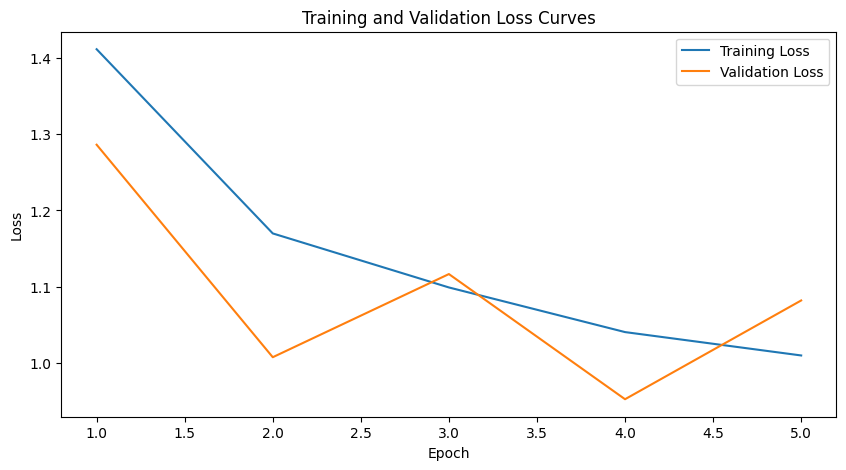

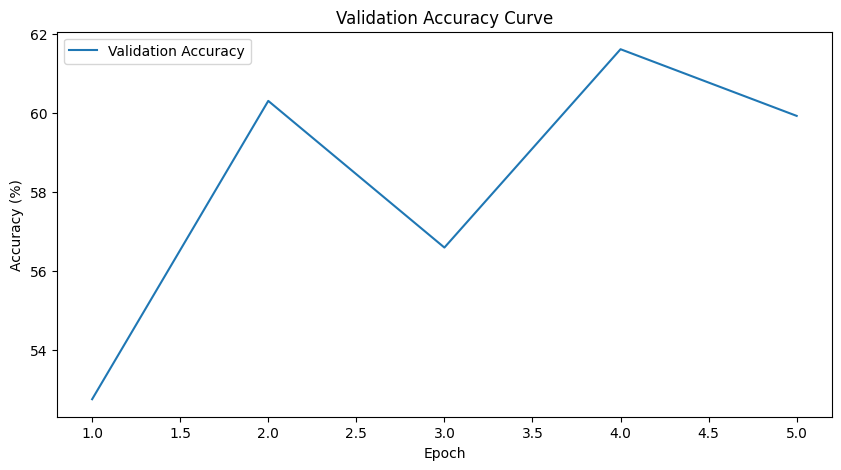

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy') # Using val_accuracies
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Curve')
plt.legend()
plt.show()